In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
train = np.loadtxt("./train.csv", delimiter = ",", skiprows = 1)
test = np.loadtxt("./test.csv",  delimiter = ",", skiprows = 1)

In [3]:
train_label = train[:,0]
train_data = train[:,1:].reshape((np.int32(train.shape[0]),28,28))
test_data = test[:,:].reshape((np.int32(test.shape[0]),28,28))

Получаем Х и У составляющую  изображения разбитого на 4 части

In [4]:
train_sobel_x = np.zeros((train_data.shape[0]*4, train_data.shape[1]//2, train_data.shape[2]//2))
train_sobel_y = np.zeros((train_data.shape[0]*4, train_data.shape[1]//2, train_data.shape[2]//2))
for i in range(len(train_data)):
    train_sobel_x[i*4] = cv2.Sobel(train_data[i, :14, :14], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_x[i*4+1] = cv2.Sobel(train_data[i, :14,14:], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_x[i*4+2] = cv2.Sobel(train_data[i, 14:, :14], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_x[i*4+3] = cv2.Sobel(train_data[i, 14:, 14:], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i*4] = cv2.Sobel(train_data[i, :14, :14], cv2.CV_64F, dx=0, dy=1, ksize=3)
    train_sobel_y[i*4+1] = cv2.Sobel(train_data[i, :14, 14:], cv2.CV_64F, dx=0, dy=1, ksize=3)
    train_sobel_y[i*4+2] = cv2.Sobel(train_data[i, 14:, :14], cv2.CV_64F, dx=0, dy=1, ksize=3)
    train_sobel_y[i*4+3] = cv2.Sobel(train_data[i, 14:, 14:], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [5]:
test_sobel_x = np.zeros((test_data.shape[0]*4, test_data.shape[1]//2, test_data.shape[2]//2))
test_sobel_y = np.zeros((test_data.shape[0]*4, test_data.shape[1]//2, test_data.shape[2]//2))
for i in range(len(test_data)):
    test_sobel_x[i*4] = cv2.Sobel(test_data[i, :14, :14], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_x[i*4+1] = cv2.Sobel(test_data[i, :14,14:], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_x[i*4+2] = cv2.Sobel(test_data[i, 14:,:14], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_x[i*4+3] = cv2.Sobel(test_data[i, 14:,14:], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i*4] = cv2.Sobel(test_data[i, :14, :14], cv2.CV_64F, dx=0, dy=1, ksize=3)
    test_sobel_y[i*4+1] = cv2.Sobel(test_data[i, :14,14:], cv2.CV_64F, dx=0, dy=1, ksize=3)
    test_sobel_y[i*4+2] = cv2.Sobel(test_data[i, 14:, :14], cv2.CV_64F, dx=0, dy=1, ksize=3)
    test_sobel_y[i*4+3] = cv2.Sobel(test_data[i, 14:, 14:], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [6]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [7]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

Вычисляем гистограммы и объеденяем в один вектор-признак

In [8]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_sobel_x), 16))
for i in range(len(train_data)*4):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=np.abs(train_g[i]))
    train_hist[i] = hist

In [9]:
test_hist = np.zeros((len(test_sobel_x), 16))
for i in range(len(test_data)*4):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=np.abs(test_g[i]))
    test_hist[i] = hist

In [83]:
train_hist.shape

(168000, 16)

Объединяем 4 вектора-признака в один большой

In [10]:
train_hist_new = np.zeros((train_hist.shape[0]//4, train_hist.shape[1]*4))
for i in range(len(train_data)):
    train_hist_new[i] = np.concatenate((train_hist[i*4], train_hist[i*4+1], train_hist[i*4+2],train_hist[i*4+3]))
    

In [11]:
test_hist_new = np.zeros((test_hist.shape[0]//4, test_hist.shape[1]*4))
for i in range(len(test_data)):
    test_hist_new[i] = np.concatenate((test_hist[i*4], test_hist[i*4+1], test_hist[i*4+2], test_hist[i*4+3]))

Нормализуем вектор

In [12]:
train_hist_new = train_hist_new / np.linalg.norm(train_hist_new, axis=1)[:, None]


In [13]:
test_hist_new = test_hist_new / np.linalg.norm(test_hist_new, axis=1)[:, None]

Сначала использовал метод опорных векторов, потом, подсмотрев в книге нашел метод случайных деревьев, который позволил поднять точность до 0,96

In [14]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist_new, test_size=0.20,
    random_state=34)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
fit_mod = GridSearchCV(LinearSVC(), {"C":[2.,5.,7., 9.]})
fit_mod.fit(x_train, y_train)

fit_mod.best_estimator_

model = LinearSVC(C = 8.9)
model.fit(x_train, y_train)

In [15]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=1000)
model2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
pred_val = model2.predict(x_val)
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

Accuracy: 0.9628571428571429
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98       782
        1.0       0.98      0.98      0.98       966
        2.0       0.95      0.98      0.97       819
        3.0       0.97      0.97      0.97       889
        4.0       0.97      0.95      0.96       847
        5.0       0.99      0.96      0.97       737
        6.0       0.94      0.97      0.95       820
        7.0       0.97      0.94      0.96       903
        8.0       0.95      0.95      0.95       803
        9.0       0.94      0.95      0.94       834

avg / total       0.96      0.96      0.96      8400



In [97]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[ 948    0    2    4    4    8    5    1    6   11]
 [   0 1184   12    0    4    0    4    2    4    4]
 [   6    6  964   26    4    0    2   12   22    3]
 [  10    1   36  964    0   36    1   17   16   11]
 [   0    8    4    1  961    1   28    5   15   32]
 [   5    2    2   27    2  857   14    8   16    3]
 [  15   18    3    2   11    9  929    0   15    7]
 [   1    9   20   13    6    1    2  994   10   59]
 [  14    9   22    8   17   23   17    9  848   45]
 [  23   11    3   10   23    4    9   60   23  867]]


In [17]:
pred_test = np.zeros(len(test_data), np.uint8)
pred_test = model2.predict(test_hist_new)

with open('submit2.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

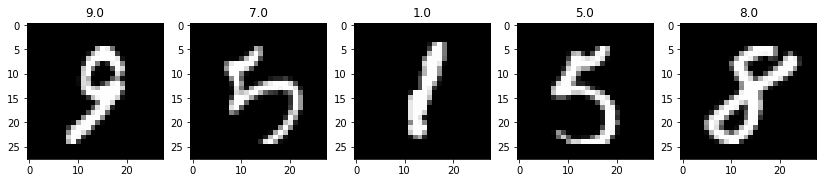

In [52]:
fig = plt.figure(figsize=(20, 10))
a = np.random.randint(1000)
for i, img in enumerate(test_data[a:a+5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[a+i-1]);

22